# Tutorial 4: Plasticity and Learning

This tutorial consists of two parts:

Part 1. Review Spike-Timing Dependent Plasticity (STDP) and its varieties.

Part 2. Implement unsupervised pattern-detection in continuous spike trains using STDP.

## Part 1: STDP and its varities

STDP alters the weights of synapses depending on the <b>relative</b> spike timing between the postsynaptic neuron and the presynaptic neuron.

<img src="http://www.scholarpedia.org/w/images/6/6a/STDP-Fig1.JPEG" alt="STDP overview (from Jesper Sjöström and Wulfram Gerstner (2010), Scholarpedia, 5(2):1362)" title="STDP overview (from Jesper Sjöström and Wulfram Gerstner (2010), Scholarpedia, 5(2):1362)" />
<i>STDP overview (from [Sjöström J, Gerstner W (2010) Spike-timing dependent plasticity. Scholarpedia](http://www.scholarpedia.org/article/Spike-timing_dependent_plasticity))</i>

Within some time windows:
 - if PRE before POST, we get Long-Term Potentiation (LTP)
 - if POST before PRE, we get Long-Term Depression (LTD)
 
The time windows for LTP and LTD are generally on the order of tens of milliseconds, and the LTD window is generally longer than the LTP window.

To implement STDP in spiking neural network models, different STDP rules can be used. In general, different rules result in different distributions of synaptic weights over the course of learning. Examples of such weight distributions are shown below.

<img src="https://journals.plos.org/plosone/article/figure/image?size=large&id=10.1371/journal.pone.0025339.g010" alt="STDP rules (from Gilson M, Fukai T (2011) Stability versus Neuronal Specialization for STDP: Long-Tail Weight Distributions Solve the Dilemma. PLoS ONE 6(10): e25339)" title="STDP rules (Gilson M, Fukai T (2011) Stability versus Neuronal Specialization for STDP: Long-Tail Weight Distributions Solve the Dilemma. PLoS ONE 6(10): e25339)" />
<i>STDP rules (from [Gilson M, Fukai T (2011) Stability versus Neuronal Specialization for STDP. PLoS ONE](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0025339))</i>

Additive STDP tends to produce competition between synapses but needs to have its weights bound to ensure network stability (e.g. to avoid over-excitation), whereas multiplicative STDP tends to produce less competition between synapses but owing to its weight-dependent manipulation of synaptic weights does not require artificial bounds. Logorithmic STDP attempts to reconcile the two.

In the following exercise, we will use the additive STDP rule, sometimes also called the exponential STDP rule:

$
\begin{equation}
 \Delta w_j=
 \begin{cases}
   a^+ \cdot e^{\big( \dfrac{t_j-t_i}{\tau^+} \big)} & \text{if}\ t_j \leq t_i & \text{(LTP)} \\
   -a^- \cdot e^{\big( - \dfrac{t_j-t_i}{\tau^-} \big)} & \text{if}\ t_j > t_i & \text{(LTD)}
 \end{cases}
\end{equation}
$

where
 - $a^+$ learning rate for LTP 
 - $a^-$ learning rate for LTD
 - $t_j$ spike time of the presynaptic neuron $j$
 - $t_i$ spike time of the postsynaptic neuron $i$
 - $\tau^+$ time constant for LTP (ms)
 - $\tau^-$ time constant for LTD (ms)

Using pre-defined paramaters which we will use in the second part of this tutorial, let's plot how the this STDP rule changes weights depending on the timing of presynaptic and postsynaptic spikes.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
plt.rcParams['figure.dpi'] = 300.0 # modifying dots per inch for figures

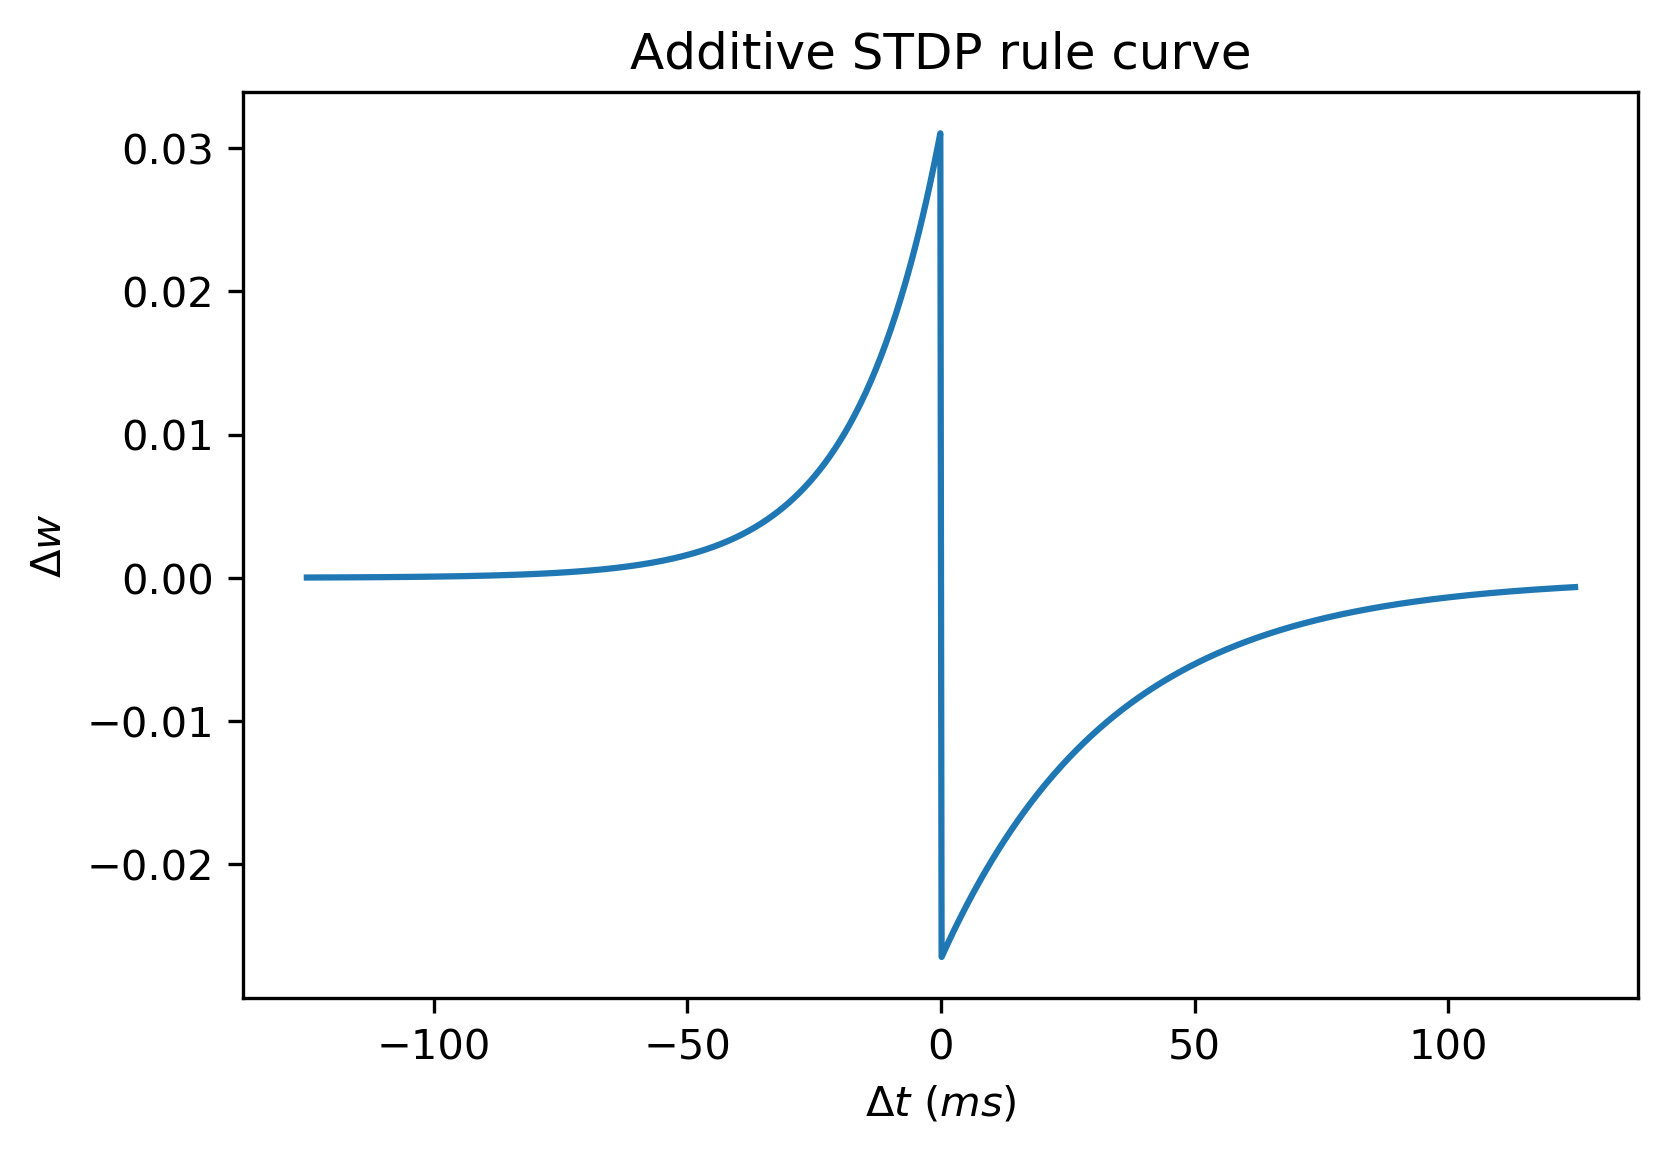

In [3]:
# pre-defined paramaters
add_STDP_paramaters = {
    'a_LTP' : 0.03125,
    'a_LTD' : 0.85 * 0.03125,
    'tau_LTP' : 16.8,
    'tau_LTD' : 33.7
}

# define the additive STDP rule as a function
def add_STDP(time_difference, params=add_STDP_paramaters):
    if time_difference <= 0:
        return params['a_LTP'] * np.exp(time_difference/params['tau_LTP'])
    elif time_difference > 0:
        return -params['a_LTD'] * np.exp(-time_difference/params['tau_LTD'])

# calculating the function different values of spike time differences
time_differences = np.linspace(-125,125,num=1_000)
weight_changes = [add_STDP(time_difference) for time_difference in time_differences]

# plotting
plt.plot(time_differences,weight_changes)
plt.title("Additive STDP rule curve")
plt.xlabel("$\Delta t\ (ms)$")
plt.ylabel("$\Delta w$")
plt.show()

### Exercise 1
- What features do you notice in this STDP curve?
- Experiment with different values in `add_STDP_paramaters`. How do each of the values change the shape of the STDP curve?
- How, in a network of neurons, could this STDP rule lead to over-excitation or network instability?

## Part 2: Unsupervised pattern-detection using STDP

In this part of the tutorial we will be replicating the results from <i>[Masquelier et al. (2008) Spike Timing Dependent Plasticity Finds the Start of Repeating Patterns in Continuous Spike Trains. PLoS ONE](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0001377)</i>. In fact, we already reproduced Figure 2 from their paper in the first part of this tutorial.

Masquelier et al. (2008) create a spiking neural network with 2,000 presynaptic neurons and just <b>one</b> postsynpatic neuron. They implement additative STDP in this network, which allows the postsynaptic neuron to learn to detect the beginning of repeating patterns of spiking activity arriving from the 2,000 presynaptic neurons. Importantly, the presynaptic neurons also have periods of random, non-patterned activity and have additional noisy spiking activity at all times.

Let's begin by constructing the spike trains of the 2,000 presynaptic neurons. We will run our simulations for 450s, so we will create 450s worth of spike trains for these neurons.

The first step is construct random activity with the following properties:
 - each presynpatic neuron will emit spikes independently, generated by a Poisson process which varies randomly in firing rate $r$ in the range of $[0,90]$ Hz
 - the rate of change in $r$ is modified by $dr$, where $dr$ starts at $0$ and is updated randomly from a uniform distribution over $[-360,360]$ Hz/s every millisecond and clipped to within $[-1800,1800]$ Hz/s
 - we will also manually add some additional spikes to guarantee that in every 50ms time bin, each neuron spikes at least once

In [4]:
num_pres = 2_000
simulation_length = 1_000 #ms

starting_hz = 54
min_r = 1
max_r = 90

min_dr_update = -360
max_dr_update = 360
min_dr = -1800
max_dr = 1800

In [5]:
def limited_cumsum(original, working, upper_limit, lower_limit):
    first_over = np.argmax(working>upper_limit)
    first_under = np.argmax(working<lower_limit)
    
    no_zero = True
    if first_over == 0 and first_over < first_under:
        #print(first_under)
        working[first_under:] = original[first_under:].cumsum()
        no_zero = False
        working = limited_cumsum(original, working, upper_limit, lower_limit)
    elif first_under == 0 and first_over > first_under:
        #print(first_over)
        working[first_over:] = original[first_over:].cumsum()
        no_zero = False
        working = limited_cumsum(original, working, upper_limit, lower_limit)
    
    if no_zero:
        if first_over < first_under:
            #print(first_over)
            working[first_over:] = original[first_over:].cumsum()
            working = limited_cumsum(original, working, upper_limit, lower_limit)
        elif first_over > first_under:
            #print(first_under)
            working[first_under:] = original[first_under:].cumsum()
            working = limited_cumsum(original, working, upper_limit, lower_limit)
    
    return working

In [6]:
def poisson_train_alt(duration=simulation_length+1):
    ds = np.random.uniform(min_dr_update, max_dr_update, duration)
    rdt = np.array(ds.cumsum())
    rdt = limited_cumsum(ds, rdt, max_dr, min_dr)
    r_w = np.insert(rdt[:-1], 0, starting_hz*1000)
    r = np.absolute(np.clip(r_w.cumsum()/1000, -90, 90))
    spikes = np.zeros((duration-1))
    for step in range(1, duration):
        if (step > 50) & (np.sum(spikes[step-50:step-1]) == 0):
            rnd_time = np.random.randint(step-50,step-1)
            spikes[rnd_time] = 1
            spikes[step-1] = 0
        else:
            spikes[step-1] = np.random.poisson(r[step-1]/1000)
    return np.clip(spikes, 0, 1)

In [7]:
def poisson_train(duration=simulation_length+1):
    spikes = []
    r = 54
    dr = 0
    for step in range(1, duration):
        if (step > 50) & (np.sum(spikes[step-50:step-1]) == 0):
            rnd_time = np.random.randint(step-50,step-1)
            spikes[rnd_time] = 1
            spikes.append(0)
        else:
            dr += np.random.uniform(min_dr_update, max_dr_update)
            dr = np.clip(dr, -1800, 1800)
            r += dr
            r = np.clip(r, 0, 90)/1000
            spikes.append(np.random.poisson(r))
    return np.clip(spikes, 0, 1)

In [8]:
tic = time.perf_counter()
pre_spikes = np.zeros([num_pres, simulation_length])
for pre in range(0, num_pres):
    pre_spikes[pre] = poisson_train()
toc = time.perf_counter()
print(toc-tic)

32.88171784500082


In [9]:
tic = time.perf_counter()
pre_spikes_alt = np.zeros([num_pres, simulation_length])
for pre in range(0, num_pres):
    pre_spikes_alt[pre] = poisson_train_alt()
toc = time.perf_counter()
print(toc-tic)

14.855036562999885


Now we will:
1. divide the presynaptic spiking activity into segments of 50ms
2. select a random 50ms segment to be considered as the "pattern"
3. copy and paste this pattern across the raster plot in a certain proportion of segments

In [123]:
def select_segment(spikes, sim_length, seg_length=50):
    num_segments = int(sim_length/seg_length)
    selection = np.random.randint(1,num_segments)
    pattern_spikes = spikes[:,selection*seg_length:selection*seg_length+seg_length]
    return pattern_spikes, selection, num_segments

In [124]:
pattern, selected_segment, num_segments = select_segment(pre_spikes, simulation_length)

In [12]:
neuron_ids_pattern = []
spike_times_pattern = []
for neuron in range(0, 200):
    for spike_time in range(0, np.shape(pattern)[1]):
        if pattern[neuron,spike_time] == 1:
            neuron_ids_pattern.append(neuron)
            spike_times_pattern.append(spike_time)

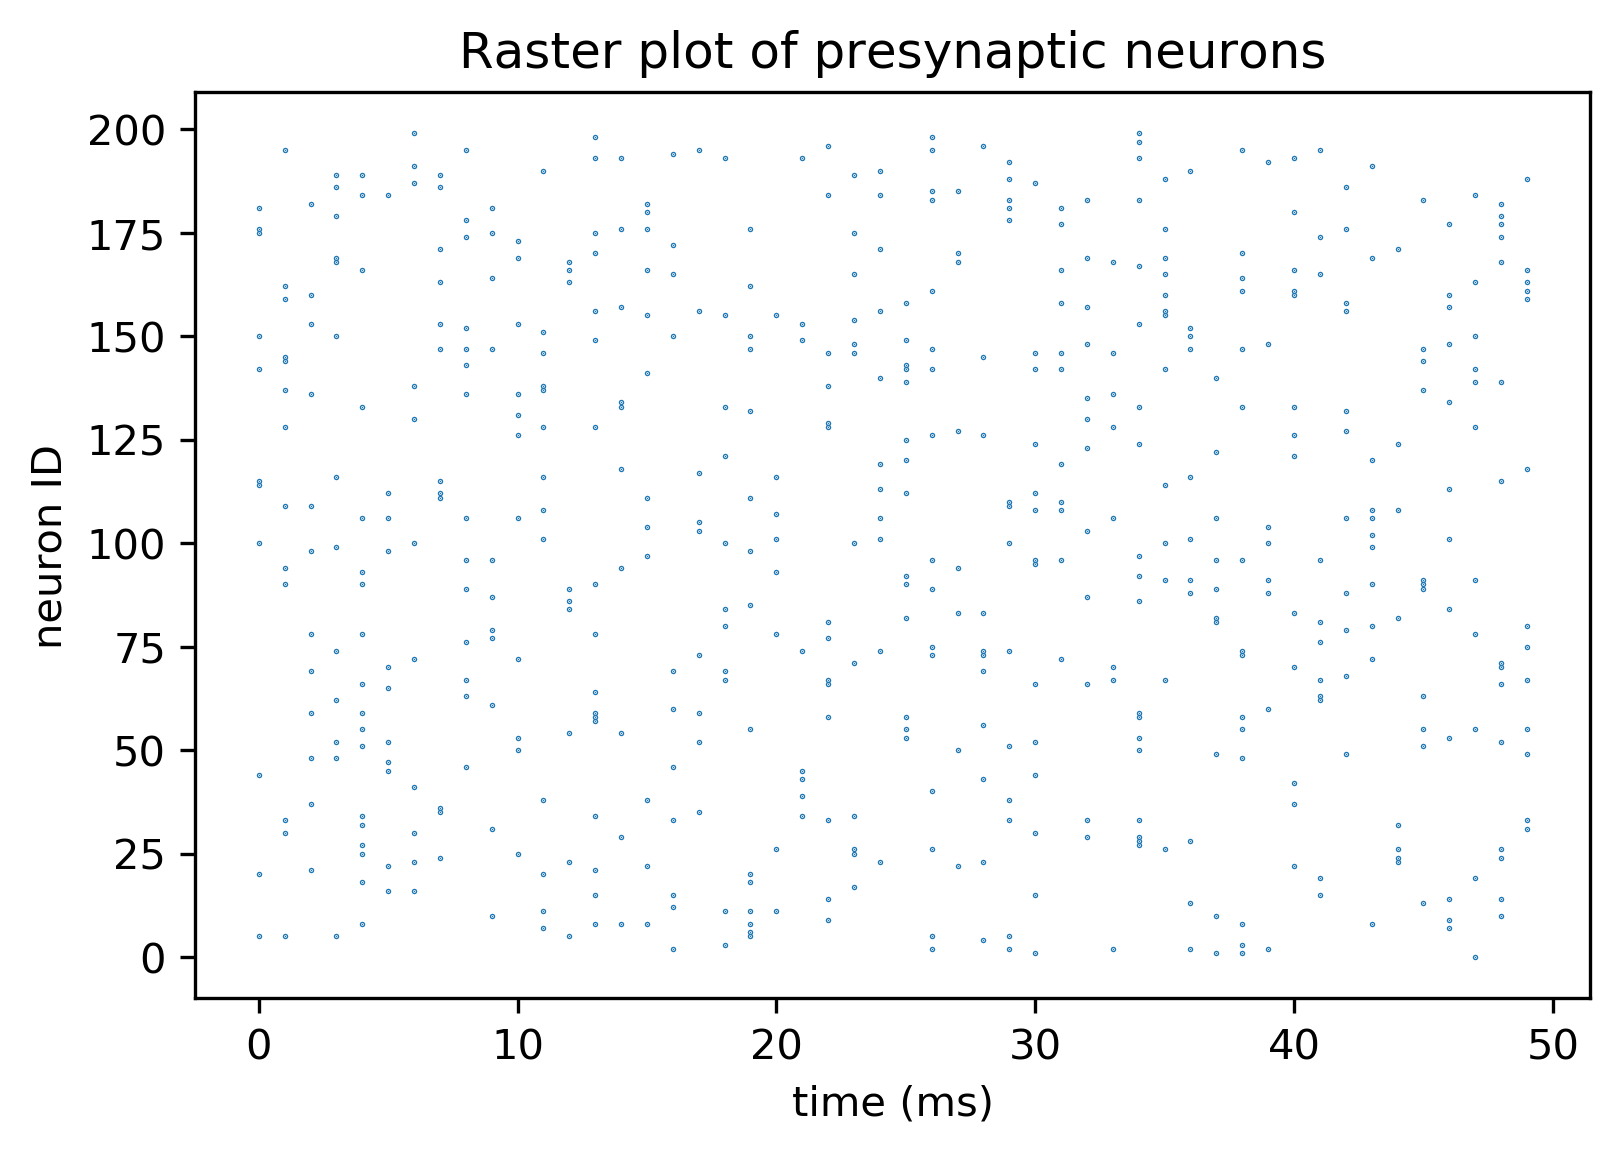

In [13]:
plt.scatter(spike_times_pattern,neuron_ids_pattern,s=0.1)
plt.title("Raster plot of presynaptic neurons")
plt.xlabel("time (ms)")
plt.ylabel("neuron ID")
plt.show()

In [75]:
def repeat_segment(pattern, selected_segment, num_segments, proportion_of_neurons=0.5, frequency_of_patterns=0.75,
                   spikes=pre_spikes, seg_length=50, num_pres=num_pres):
    output = np.array(spikes)
    output_identities = np.zeros(np.shape(spikes))
    num_repeats = round(frequency_of_patterns*num_segments)
    idx_repeats = random.sample(range(num_segments), num_repeats)
    for i in range(0, num_repeats-1):
        output[0:int(num_pres*proportion_of_neurons),idx_repeats[i]*seg_length:idx_repeats[i]*seg_length+seg_length] = pattern[0:int(num_pres*proportion_of_neurons),:]
        output_identities[0:int(num_pres*proportion_of_neurons),idx_repeats[i]*seg_length:idx_repeats[i]*seg_length+seg_length] = np.ones(np.shape(pattern))[0:int(num_pres*proportion_of_neurons),:]
    return output, output_identities

In [15]:
proportion_of_neurons = 0.5
frequency_of_patterns = 0.25

pre_spikes_wrepeats, output_identities = repeat_segment(pattern, selected_segment, num_segments,
                                    proportion_of_neurons, frequency_of_patterns,
                                    spikes=pre_spikes, seg_length=50, num_pres=num_pres)

In [36]:
num_of_pattern_spikes = np.sum(output_identities)
print("Number of spikes added:", int(num_of_pattern_spikes))

Number of spikes added: 200000


Finally, we add an addition $10\ \text{Hz}$ noise to all neurons at all times.

In [50]:
def extra_poisson_noise(duration=simulation_length, num_pres=num_pres, frequency=10):
    noise = np.zeros([num_pres, duration])
    for neuron in range(1, num_pres):
        noise[neuron-1] = np.random.poisson(frequency/1000, duration)
    return noise

In [18]:
pre_spikes_wrepeats += extra_poisson_noise()
pre_spikes_wrepeats = np.clip(pre_spikes_wrepeats, 0, 1)

Now let's plot the spikes as raster plots and visualising their firing rates

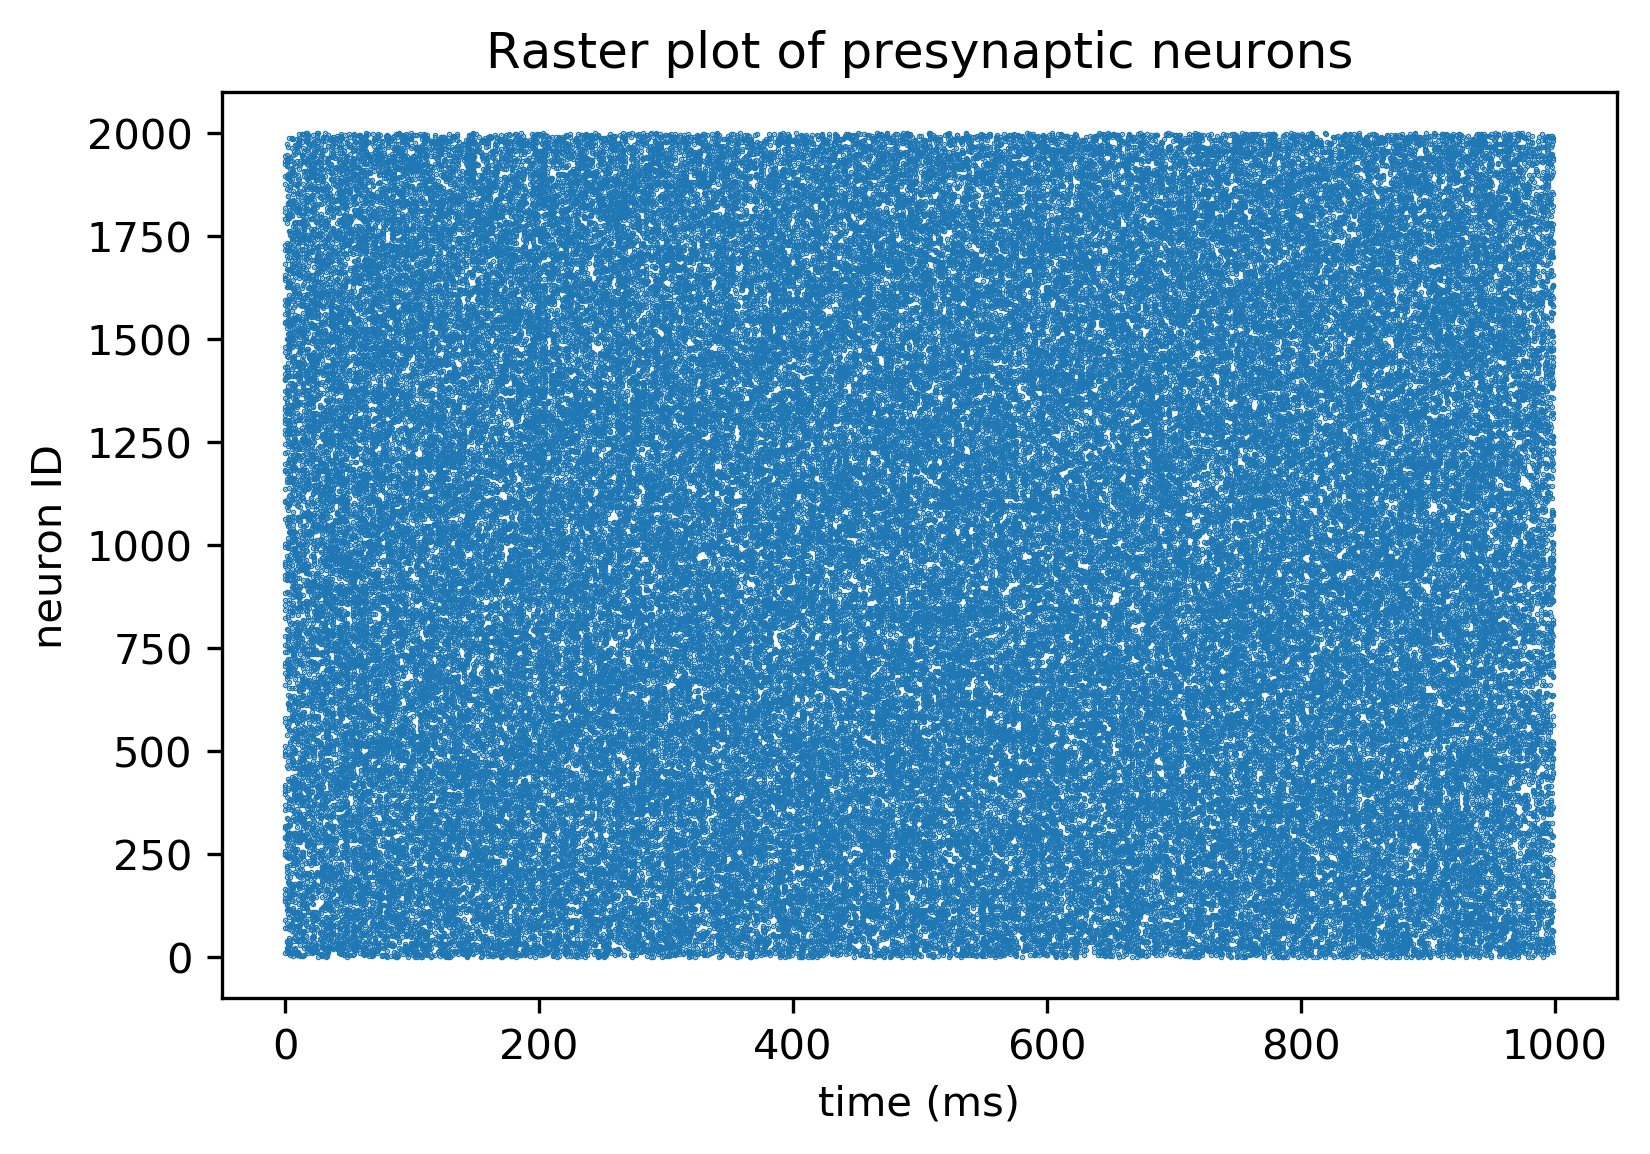

In [19]:
neuron_ids = []
spike_times = []
for neuron in range(0, num_pres):
    for spike_time in range(0, simulation_length):
        if pre_spikes[neuron,spike_time] == 1:
            neuron_ids.append(neuron)
            spike_times.append(spike_time)

plt.scatter(spike_times,neuron_ids,s=0.1)
plt.title("Raster plot of presynaptic neurons")
plt.xlabel("time (ms)")
plt.ylabel("neuron ID")
plt.show()

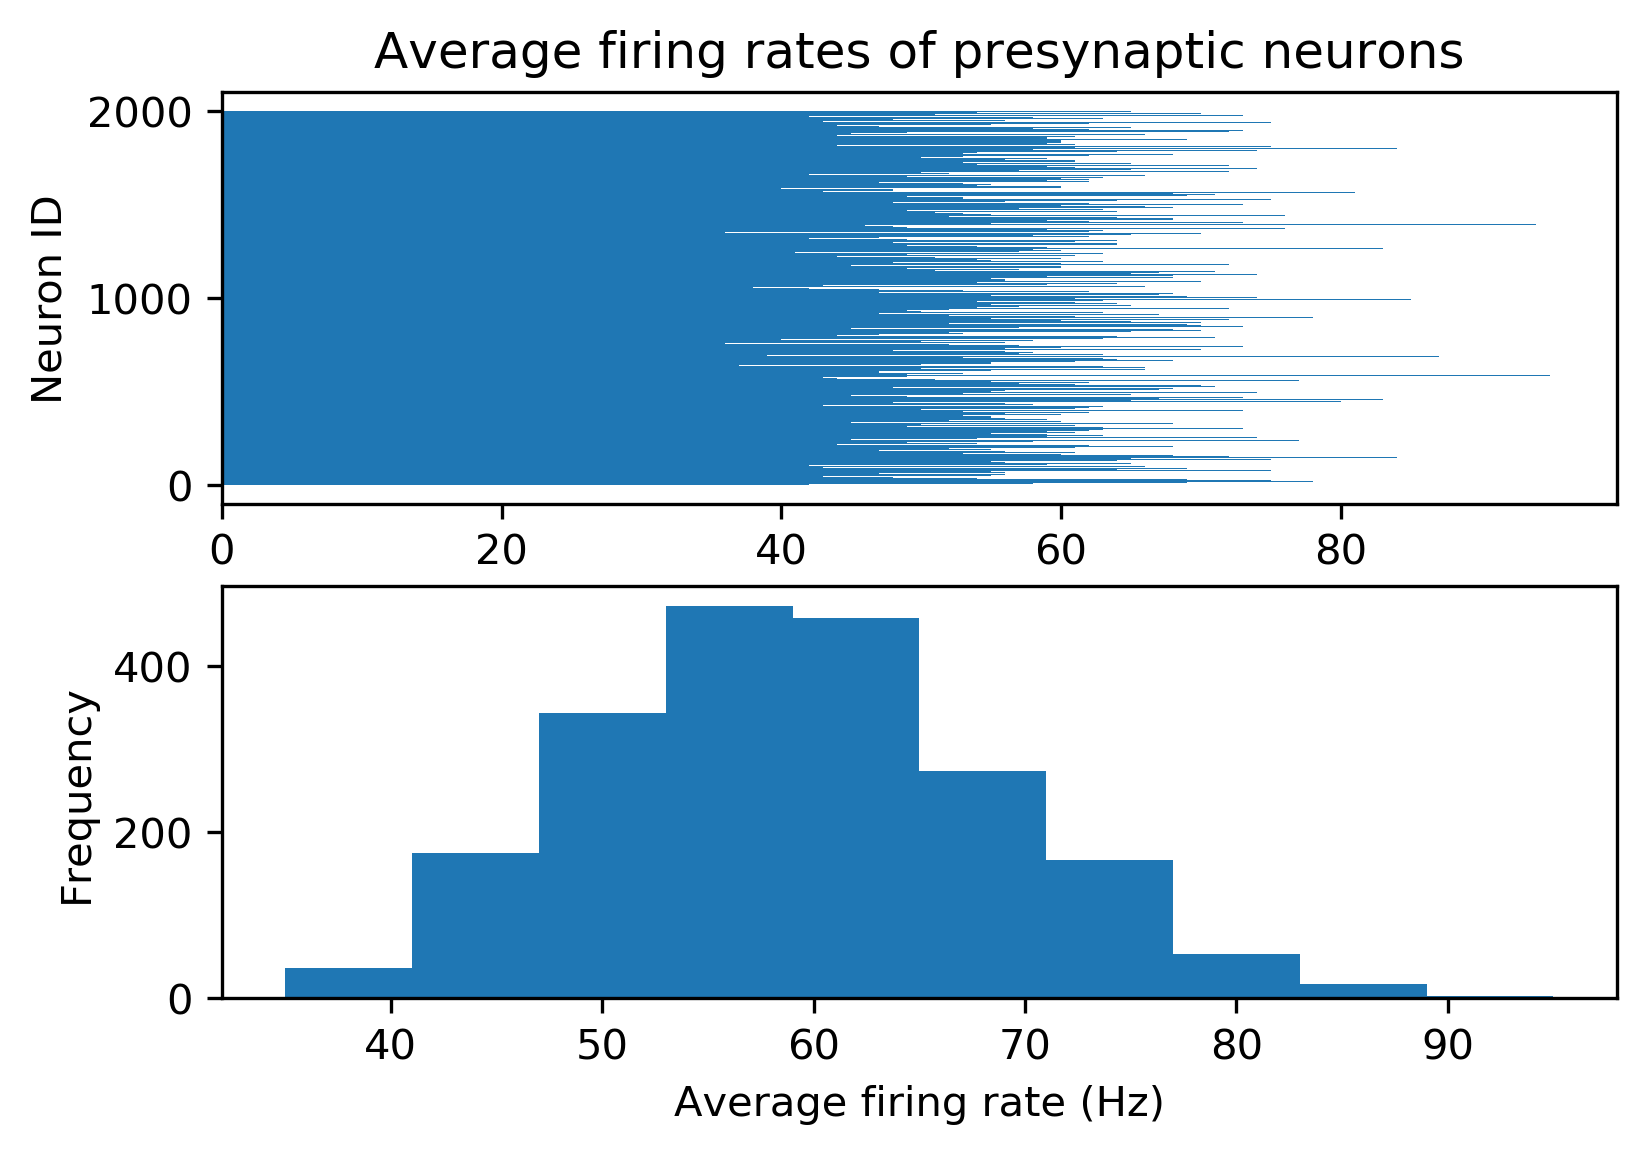

In [20]:
firing_rates = []
for neuron in range(0, num_pres):
    firing_rates.append((np.sum(pre_spikes[neuron])/simulation_length)*1_000)

pre_IDs = list(range(0, num_pres))

fig, axes = plt.subplots(2, 1)

axes[0].barh(pre_IDs, firing_rates, height=1)
axes[0].set_title("Average firing rates of presynaptic neurons")
axes[0].set_ylabel("Neuron ID")

axes[1].hist(firing_rates)
axes[1].set_xlabel("Average firing rate (Hz)")
axes[1].set_ylabel("Frequency")

plt.show()

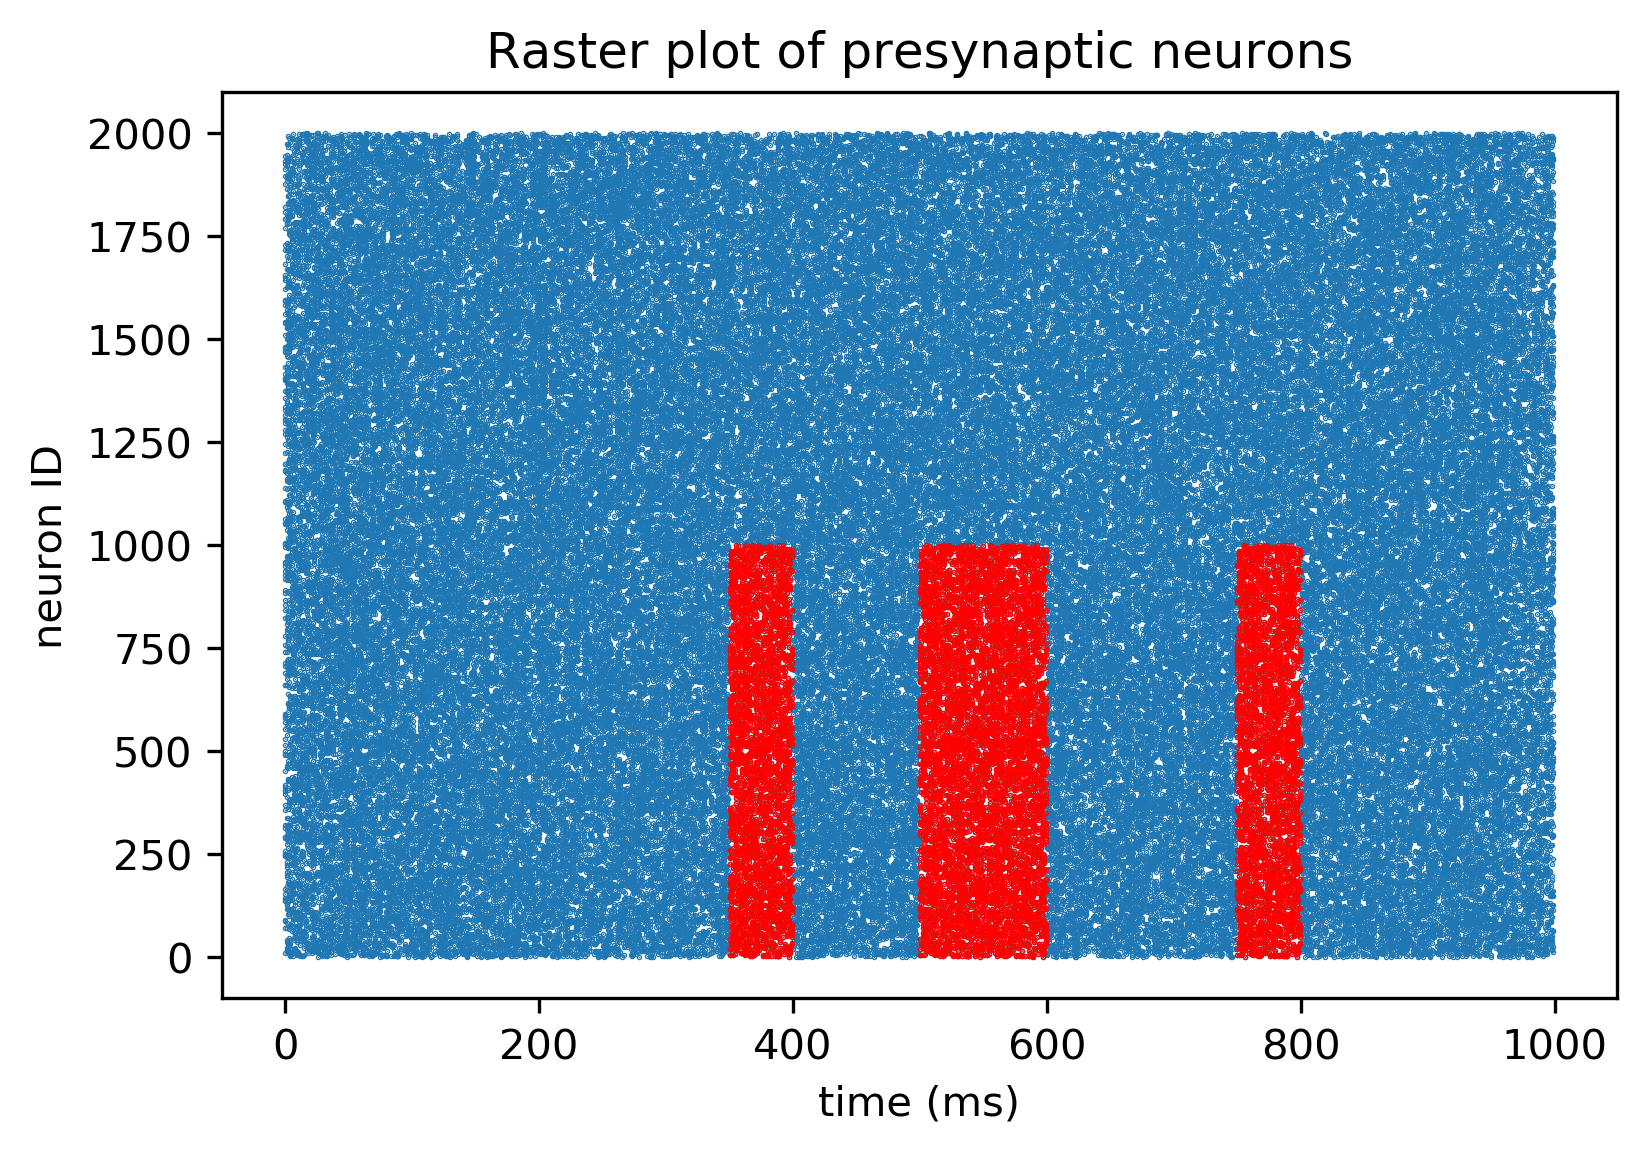

In [21]:
neuron_ids_wrepeats = []
spike_times_wrepeats = []
pattern_ids = []
pattern_spikes = []
for neuron in range(0, num_pres):
    for spike_time in range(0, simulation_length):
        if pre_spikes_wrepeats[neuron,spike_time] == 1:
            neuron_ids_wrepeats.append(neuron)
            spike_times_wrepeats.append(spike_time)
            if output_identities[neuron,spike_time] == 1:
                pattern_ids.append(neuron)
                pattern_spikes.append(spike_time)

plt.scatter(spike_times_wrepeats,neuron_ids_wrepeats,s=0.1)
plt.scatter(pattern_spikes,pattern_ids,s=0.1,c='red')
plt.title("Raster plot of presynaptic neurons")
plt.xlabel("time (ms)")
plt.ylabel("neuron ID")
plt.show()

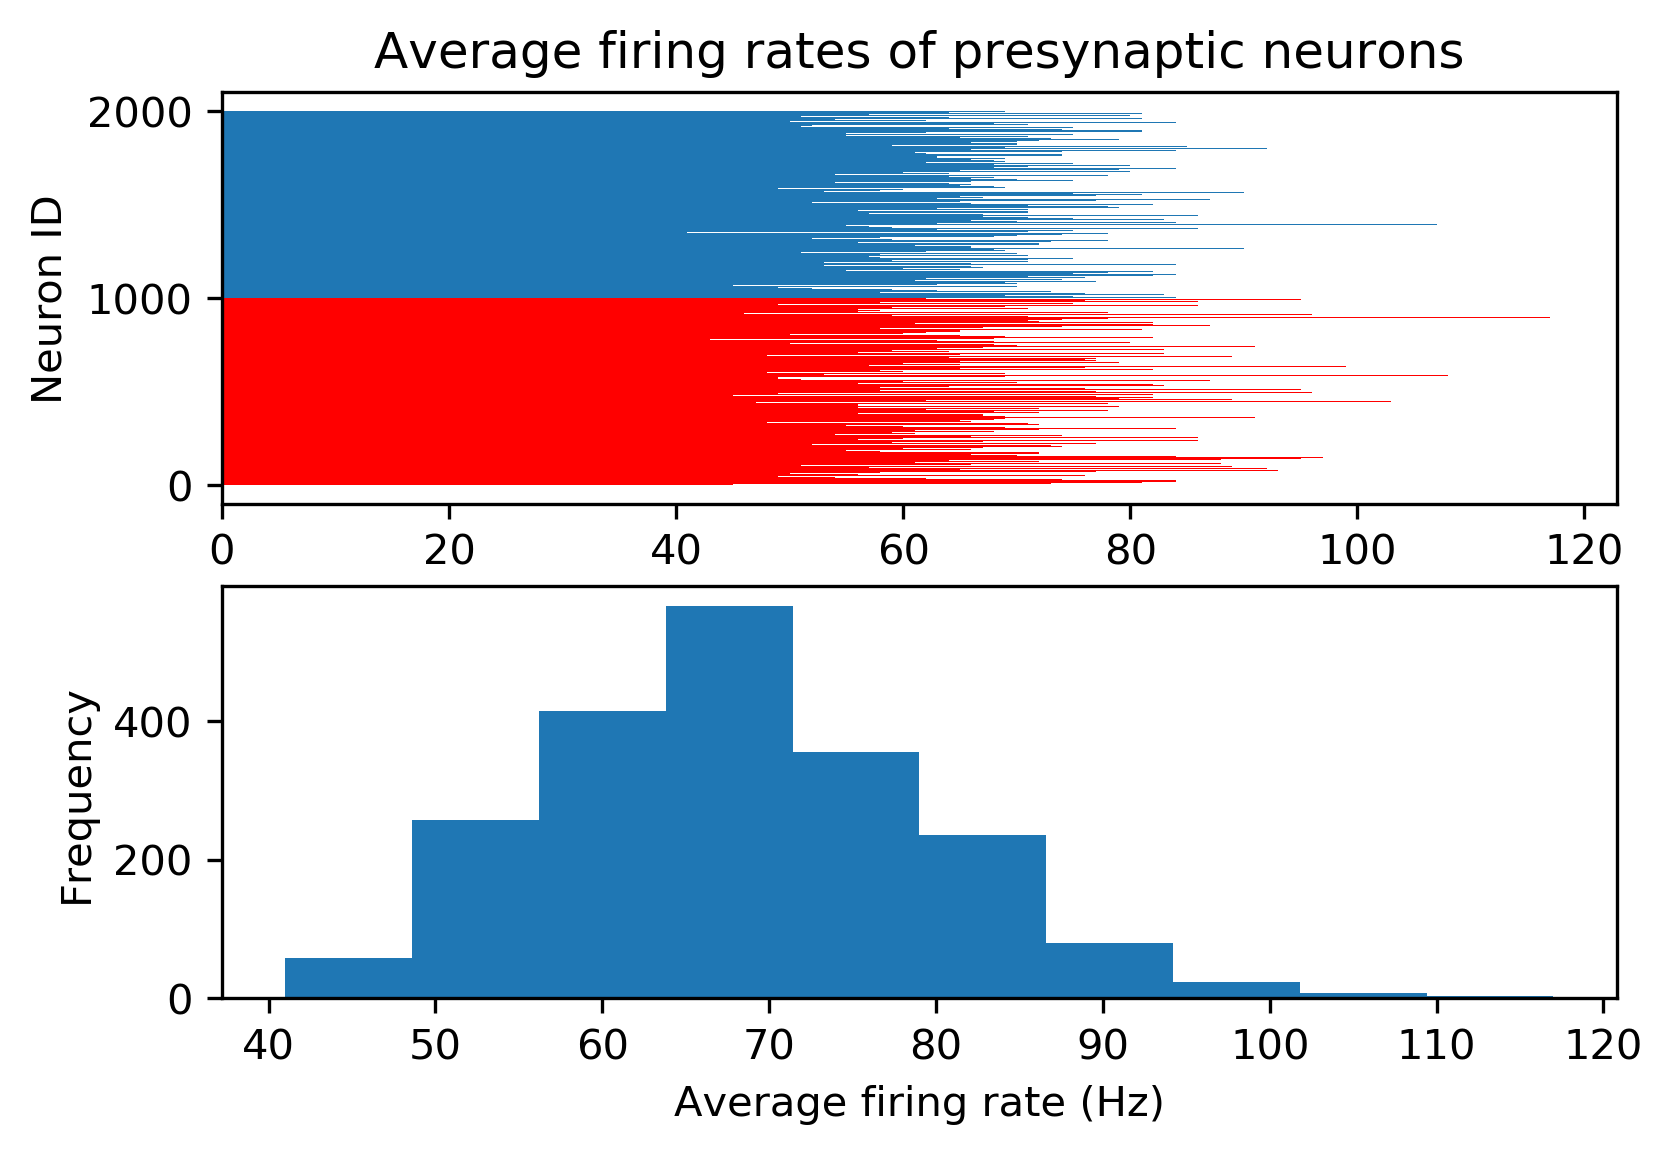

In [22]:
firing_rates_wrepeats = []
for neuron in range(0, num_pres):
    firing_rates_wrepeats.append((np.sum(pre_spikes_wrepeats[neuron])/simulation_length)*1_000)

pre_IDs_wrepeats = list(range(0, num_pres))

fig, axes = plt.subplots(2, 1)

axes[0].barh(pre_IDs_wrepeats[:int(num_pres*proportion_of_neurons)], firing_rates_wrepeats[:int(num_pres*proportion_of_neurons)], height=1, color='red')
axes[0].barh(pre_IDs_wrepeats[int(num_pres*proportion_of_neurons):], firing_rates_wrepeats[int(num_pres*proportion_of_neurons):], height=1)
axes[0].set_title("Average firing rates of presynaptic neurons")
axes[0].set_ylabel("Neuron ID")

axes[1].hist(firing_rates_wrepeats)
axes[1].set_xlabel("Average firing rate (Hz)")
axes[1].set_ylabel("Frequency")

plt.show()

With these paramaters, we can embed a repeating pattern within some pseduo-random, spontaneous activity.

However, learning takes time! And we have only been simulating 1s of activity. In our task, the authors reported they needed 13.5s of activity (or 700 pattern presentations) for the neuron to show signs of learning to recognise the pattern.

<img src="https://journals.plos.org/plosone/article/figure/image?size=large&id=10.1371/journal.pone.0001377.g004" alt="STDP rules (from Gilson M, Fukai T (2011) Stability versus Neuronal Specialization for STDP: Long-Tail Weight Distributions Solve the Dilemma. PLoS ONE 6(10): e25339)" title="STDP rules (Gilson M, Fukai T (2011) Stability versus Neuronal Specialization for STDP: Long-Tail Weight Distributions Solve the Dilemma. PLoS ONE 6(10): e25339)" />
<i> Figure 4 from Masquelier et al. 2008: <b>Overview of the 450 s simulation.</b>
Here we plotted the membrane potential as a function of simulation time, at the beginning, middle, and end of the simulation. Grey rectangles indicate pattern presentations. (a) At the beginning of the simulation the neuron is non-selective because the synaptic weights are all equal. It thus fires periodically, both inside and outside the pattern. (b) At t≈13.5 s, after about 70 pattern presentations and 700 discharges, selectivity to the pattern is emerging: gradually the neuron almost stops discharging outside the pattern (no false alarms), while it does discharge most of the time the pattern is present (high hit rate), here even twice (c) End of the simulation. The system has converged (by saturation). Postsynaptic spike latency is about 4 ms. Hit rate is 99.1% with no false alarms (estimated on the last 150 s). </i>

We will therefore use some pre-computed spontaneous activity prepared earlier, found in the file `spont_100s_alt.npy`. It contains 100s of pseduo-random, spontaneous activity for us to use in our simulations. Warning, it is a large file at ~1.6GB!

In [127]:
simulation_length_100s = 100_000
pre_spikes_wrepeats_100s = np.load("spont_100s_alt.npy")
pattern, selected_segment, num_segments = select_segment(pre_spikes_wrepeats_100s, simulation_length_100s)

In [140]:
proportion_of_neurons = 0.5
frequency_of_patterns = 0.25

pre_spikes_wrepeats_100s, output_identities_100s = repeat_segment(pattern, selected_segment, num_segments,
                                    proportion_of_neurons, frequency_of_patterns,
                                    spikes=pre_spikes_wrepeats_100s, seg_length=50, num_pres=num_pres)

pre_spikes_wrepeats_100s += extra_poisson_noise(simulation_length_100s)
pre_spikes_wrepeats_100s = np.clip(pre_spikes_wrepeats_100s, 0, 1)

num_of_pattern_spikes_100s = np.sum(output_identities_100s)
print("Number of spikes added in 100s:", int(num_of_pattern_spikes_100s))

Number of spikes added in 100s: 24950000


### Now we are ready to use these spike trains to train a postsynaptic neuron!

In [151]:
import nest

Now that we've created our neurons in NEST, we need to connect them with synapses capable of STDP.

NEST contains many STDP synapse rules. Which one should we use? We said earlier that we will use an additive/multiplicative STDP rule, however that is not the only parameter to consider. Another consideration is how to pair two continuous spikes trains such that we can apply STDP appropriately to all presynaptic spikes $j$ coming to the postsynaptic neuron $i$.

A list of STDP models implemented in NEST can be found here: https://nest-simulator.readthedocs.io/en/latest/models/stdp.html

The following models correspond to the below figure for pairing of spikes for STDP:
 - `stdp_nn_symm_synapse` (panel A)
 - `stdp_nn_pre-centered_synapse` (panel B)
 - `stdp_nn_restr_synapse` (panel C)

<i>[Masquelier et al. (2008)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0001377)</i> uses something akin to panel C, so we will use NEST's `stdp_nn_restr_synapse` model to connect our presynaptic neurons with the postsynpatic neuron.

<img src="https://media.springernature.com/original/springer-static/image/art%3A10.1007%2Fs00422-008-0233-1/MediaObjects/422_2008_Article_233_Fig7.jpg"/>
<i> Figure 7 from [Morrison et al. 2008](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2799003).
Examples of nearest neighbor spike pairing schemes for a presynaptic neuron j and a postsynaptic neuron i. In each case, the dark gray indicate which pairings contribute toward depression of a synapse, and light gray indicate which pairings contribute toward potentiation. a Symmetric interpretation: each presynaptic spike is paired with the last postsynaptic spike, and each postsynaptic spike is paired with the last presynaptic spike (Morrison et al. 2007). b Presynaptic centered interpretation: each presynaptic spike is paired with the last postsynaptic spike and the next postsynaptic spike (Izhikevich and Desai 2003; Burkitt et al. 2004: Model II). c Reduced symmetric interpretation: as in c but only for immediate pairings (Burkitt et al. 2004: Model IV, also implemented in hardware by Schemmel et al. 2006)</i>

In [195]:
spike_indicies_all = np.where(pre_spikes_wrepeats_100s==1)

In [207]:
spike_indicies = []
for pre in range(0, num_pres):
    spike_indicies.append(spike_indicies_all[1][spike_indicies_all[0]==pre])

In [235]:
source = nest.Create('spike_generator', num_pres)
nest.SetStatus(source, [{"spike_times": spike_indicies[x].astype(float)+1} for x in range(0,num_pres)])

In [254]:
nest.GetStatus(source)[0]

{'allow_offgrid_spikes': False,
 'element_type': <SLILiteral: stimulator>,
 'frozen': False,
 'global_id': 8609,
 'local': True,
 'local_id': 8609,
 'model': <SLILiteral: spike_generator>,
 'node_uses_wfr': False,
 'origin': 0.0,
 'parent': 0,
 'precise_times': False,
 'shift_now_spikes': False,
 'spike_multiplicities': array([], dtype=int64),
 'spike_times': array([1.0000e+01, 1.4000e+01, 3.1000e+01, ..., 9.9988e+04, 9.9997e+04,
        9.9999e+04]),
 'spike_weights': array([], dtype=float64),
 'start': 0.0,
 'stop': 1.7976931348623157e+308,
 'supports_precise_spikes': False,
 'thread': 0,
 'thread_local_id': -1,
 'vp': 0}

In [251]:
pre_pop = nest.Create('parrot_neuron', num_pres)
nest.Connect(source, pre_pop)

In [255]:
nest.GetStatus(pre_pop)[0]

{'archiver_length': 0,
 'beta_Ca': 0.001,
 'Ca': 0.0,
 'element_type': <SLILiteral: neuron>,
 'frozen': False,
 'global_id': 12609,
 'local': True,
 'local_id': 12609,
 'model': <SLILiteral: parrot_neuron>,
 'node_uses_wfr': False,
 'parent': 0,
 'supports_precise_spikes': False,
 'synaptic_elements': {},
 't_spike': -1.0,
 'tau_Ca': 10000.0,
 'tau_minus': 20.0,
 'tau_minus_triplet': 110.0,
 'thread': 0,
 'thread_local_id': -1,
 'vp': 0}

In [256]:
STDP_paramaters = {
    'a_LTP' : 0.03125,
    'a_LTD' : 0.85 * 0.03125,
    'tau_LTP' : 16.8,
    'tau_LTD' : 33.7
}
post = nest.Create('iaf_psc_alpha', params={"tau_minus": add_STDP_paramaters['tau_LTD']})

In [259]:
syn_dict = {"model": "stdp_synapse",
            "tau_plus": add_STDP_paramaters['tau_LTP'],
            "weight": 0.475,
            "mu_plus": add_STDP_paramaters['a_LTP'], 
            "mu_minus": add_STDP_paramaters['a_LTD'],
            "delay": 1.0}
nest.Connect(pre_pop, post, "all_to_all", syn_dict)

In [260]:
len(nest.GetConnections(pre_pop, post, synapse_model="stdp_synapse"))

2000

In [ ]:
nest.GetStatus(post)

## Challenge Exercise

Consider whether and how your network could learn multiple patterns, e.g. would you need to add more post-synaptic neurons to the network? Hint: see <i>[Masquelier et al. (2009) Competitive STDP-Based Spike Pattern Learning. Neural Computation](https://www.ncbi.nlm.nih.gov/pubmed/19718815)</i>.